In [1]:
#!pip install backtrader

In [2]:
from datetime import datetime
import backtrader as bt
import matplotlib

matplotlib.__version__

'3.2.2'

In [3]:
cerebro = bt.Cerebro()

In [4]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    
    params = (
        ('maperiod_fast', 8),
        ('maperiod_slow', 34),
    )

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma_fast = bt.indicators.ExponentialMovingAverage(self.datas[0], period=self.params.maperiod_fast)
        self.sma_slow = bt.indicators.ExponentialMovingAverage(self.datas[0], period=self.params.maperiod_slow)

    def log(self, txt, dt=None):
        '''Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm 
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
    
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset order status to prepare for next order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')

    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log(f'Close, {self.dataclose[0]}')

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.sma_fast[0] > self.sma_slow[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log(f'BUY CREATE, {self.dataclose[0]}')

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.sma_fast[0] < self.sma_slow[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log(f'SELL CREATE, {self.dataclose[0]}')

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [5]:
# Add a strategy
cerebro.addstrategy(TestStrategy)

0

In [6]:
data = bt.feeds.YahooFinanceData(dataname='^NSEI', fromdate=datetime(2010, 1, 1),
                                  todate=datetime(2021, 2, 16))
cerebro.adddata(data)

In [7]:
cerebro.broker.setcash(10_00_000.0)

In [8]:
# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=3) #buy/sell 3 futures

In [9]:
# Set the commission - Rs 20 per transcation
cerebro.broker.setcommission(commission=20, margin=1_70_000)

In [10]:
starting = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {starting}')

Starting Portfolio Value: 1000000.0


In [11]:
%%time
cerebro.run()

2010-03-08, BUY CREATE, 5124.0
2010-03-09, BUY EXECUTED, Price: 5121.05, Cost: 510000.0, Comm 60.0
2010-05-05, SELL CREATE, 5124.9
2010-05-06, SELL EXECUTED, Price: 5124.4, Cost: 510000.0, Comm 60.0
2010-05-06, OPERATION PROFIT, GROSS: 10.049999999998363, NET: -109.95000000000164
2010-06-14, BUY CREATE, 5197.7
2010-06-15, BUY EXECUTED, Price: 5201.3, Cost: 510000.0, Comm 60.0
2010-11-19, SELL CREATE, 5890.3
2010-11-22, SELL EXECUTED, Price: 5920.899999999999, Cost: 510000.0, Comm 60.0
2010-11-22, OPERATION PROFIT, GROSS: 2158.7999999999984, NET: 2038.7999999999984
2010-12-24, BUY CREATE, 6011.6
2010-12-27, BUY EXECUTED, Price: 6013.3, Cost: 510000.0, Comm 60.0
2011-01-10, SELL CREATE, 5762.85
2011-01-11, SELL EXECUTED, Price: 5767.95, Cost: 510000.0, Comm 60.0
2011-01-11, OPERATION PROFIT, GROSS: -736.0500000000011, NET: -856.0500000000011
2011-03-25, BUY CREATE, 5654.25
2011-03-28, BUY EXECUTED, Price: 5645.25, Cost: 510000.0, Comm 60.0
2011-05-04, SELL CREATE, 5537.15
2011-05-05, SEL

2020-01-30, SELL CREATE, 12035.8
2020-01-31, SELL EXECUTED, Price: 12100.4, Cost: 510000.0, Comm 60.0
2020-01-31, OPERATION PROFIT, GROSS: 1529.0999999999913, NET: 1409.0999999999913
2020-02-13, BUY CREATE, 12174.65
2020-02-14, BUY EXECUTED, Price: 12190.15, Cost: 510000.0, Comm 60.0
2020-02-17, SELL CREATE, 12045.8
2020-02-18, SELL EXECUTED, Price: 12028.25, Cost: 510000.0, Comm 60.0
2020-02-18, OPERATION PROFIT, GROSS: -485.6999999999989, NET: -605.6999999999989
2020-05-29, BUY CREATE, 9580.3
2020-06-01, BUY EXECUTED, Price: 9726.85, Cost: 510000.0, Comm 60.0
2020-09-24, SELL CREATE, 10805.55
2020-09-25, SELL EXECUTED, Price: 10910.4, Cost: 510000.0, Comm 60.0
2020-09-25, OPERATION PROFIT, GROSS: 3550.649999999998, NET: 3430.649999999998
2020-10-05, BUY CREATE, 11503.35
2020-10-06, BUY EXECUTED, Price: 11603.450000000003, Cost: 510000.0, Comm 60.0
CPU times: user 958 ms, sys: 33.1 ms, total: 991 ms
Wall time: 1.89 s


In [12]:
ending = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending}')

Final Portfolio Value: 1023736.3000000007


In [13]:
print(f'Returns: {round(((ending - starting)/starting)*100, 2)}%')

Returns: 2.37%


<IPython.core.display.Javascript object>


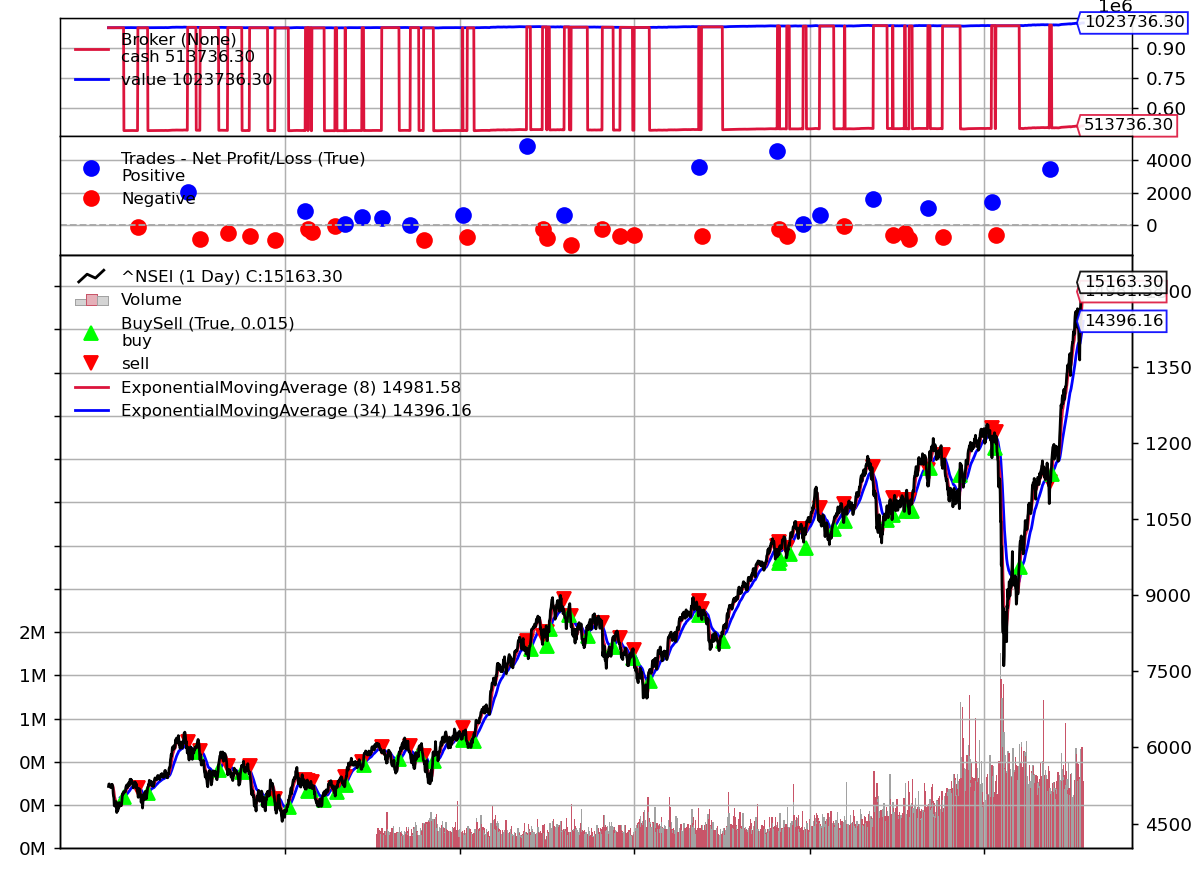

[[<Figure size 640x480 with 4 Axes>]]

In [14]:
cerebro.plot()